In [194]:
import geemap,ee
ee.Authenticate()
ee.Initialize(project='ee-aesmatias')
#Aqui, por google colab no tuve que usar un token ni nada, pero se requiere autenticacion

# IMT2118 - Control 2

Recuerde de la Tarea 1, el caso del gran incendio de los Cerros Rocuant y San Roque de la región de Valparaíso, ocurrido el **24 de diciembre de 2019** ([Cooperativa.cl](https://cooperativa.cl/noticias/pais/region-de-valparaiso/mas-de-100-casas-afectadas-por-incendio-en-el-cerro-rocuant-de-valparaiso/2019-12-24/162255.html),[Biobiochile.cl](https://www.biobiochile.cl/noticias/nacional/region-de-valparaiso/2021/11/11/a-casi-2-anos-del-gran-incendio-vecinos-de-cerros-rocuant-y-san-roque-acusan-lenta-reconstruccion.shtml)).

En este Control, ud. usará imágenes de Sentinel 2 para analizar la extensión de las zonas quemadas.

#### 1. Identifique la zona geográfica del incendio, y genere en GEE una "área de interés" o AOI, para filtrar y seleccionar imágenes.

El shapefile entregado, corresponde al catastro de viviendas afectadas por el incendio.

<Axes: >

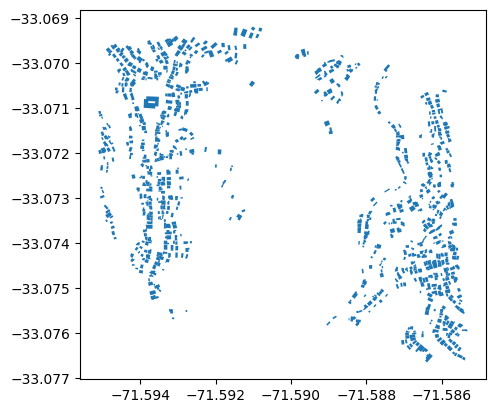

In [195]:
import geopandas as gpd
rocuant=gpd.read_file('Rocuant.gpkg')
rocuant.plot()

In [196]:
#Cargamos las primeras entradas del GDF para ver su contenido
rocuant.head()

,id,material,n_pisos,orientacio,dist_veget,dist_foco,tamano,dist_estru,prep_vivie,elevacion_,...,cord_y,ac_supresi,codigo_pol,dist_sup,index_righ,Id_1,poligono,sup,elevacion,geometry
0,0,Liviano,1,SW,1.637510,1039.73,12.6146,2.90475,No,217.771,...,6.337341e+06,Directo,1204,985.865601,0,0,58.5852,58.5852,72.009,"POLYGON ((-71.58847 -33.07567, -71.58845 -33.0..."
1,0,Liviano,1,NW,0.598048,1036.82,121.0670,1.86586,No,221.043,...,6.337343e+06,Directo,1205,985.865601,0,0,58.5852,58.5852,75.281,"POLYGON ((-71.58841 -33.07563, -71.58834 -33.0..."
2,0,Liviano,1,NW,0.811124,1026.42,142.7670,1.86586,No,223.828,...,6.337334e+06,Directo,1206,994.872131,0,0,58.5852,58.5852,78.066,"POLYGON ((-71.58828 -33.0757, -71.58815 -33.07..."
3,0,Liviano,1,NW,0.000000,1058.06,63.9348,3.38041,No,221.506,...,6.337361e+06,Directo,1207,992.144653,0,0,58.5852,58.5852,75.744,"POLYGON ((-71.58827 -33.07551, -71.58823 -33.0..."
4,0,Liviano,1,NW,0.072906,1065.39,88.9411,2.35765,No,222.784,...,6.337372e+06,Directo,1208,1018.414001,0,0,58.5852,58.5852,77.022,"POLYGON ((-71.58808 -33.07548, -71.58807 -33.0..."


#Vemos que el GDF esta compuesto por datos tabulares y la geometria de la columna geometry, por lo que podemos usar su geometria para obtener los límites (bounds) y con eso determinar el AOI que se usará en el GEE (Google Earth Engine)

In [197]:
from shapely.geometry import Polygon
#complete estos códigos

minx,miny,maxx,maxy = rocuant.total_bounds #Aquí, total_bounds es un metodo de un
#GDF que retorna coordenadas limites segun el mapa vectorial entregado (Rocuant.gpkg)
xy=[[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy]]

aoi = Polygon(xy)
#Convertimos el área de interés a ee.Geometry, para poder usarlo más abajo:
aoi_ee = ee.Geometry.Polygon(list(aoi.exterior.coords))

#### 2. Seleccione una imagen de la colección Sentinel 2 inmediatamente antes, y otra después del incendio (lo más cercano posible a la fecha del incendio).



In [198]:
startDateString = "2019-12-20"; #Fecha cinco días antes del incendio, hay problemas con fechas
#posteriores a esta, probablemente no hay registros.
#(Esto se debería automatizar con algún bucle posteriormente)
endDateString = "2019-12-25" ; #Fecha 1 día posterior al incendio, no se pudo obtener una mejor
#Muestra de imagen, ya que las fechas posteriores están menos visibles, y la del día con fecha
# 30 del mes 12 del año 2019 tiene nubes por encima: la muestra elegida tiene humo, pero no en
# la zona de interés (el cerro mencionado en el enunciado).


# Convertir las fechas a objetos ee.Date
startDate = ee.Date(startDateString)
endDate = ee.Date(endDateString)

collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
.filterBounds(aoi_ee)

images=collection.aggregate_array('system:id').getInfo()

#Obtenemos las imágenes previa y posterior al incendio, filtrando
#Por la fecha definida en variables al inicio de la celda,
#Este codigo filtra imagenes desde startDate hasta el final de ese mismo dia,
#que ocurre cuando comienza el dia posterior, en startDate.advance(1, 'day'):
image_pre = collection.filterDate(startDate, startDate.advance(1, 'day'))
image_post = collection.filterDate(endDate, endDate.advance(1,'day'))

#Mostramos la info de las img
print(image_pre.first().getInfo())
print(image_post.getInfo())


{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32719', 'crs_transform': [60, 0, 199980, 0, -60, 6400000]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32719', 'crs_transform': [10, 0, 199980, 0, -10, 6400000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32719', 'crs_transform': [10, 0, 199980, 0, -10, 6400000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32719', 'crs_transform': [10, 0, 199980, 0, -10, 6400000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32719', 'crs_transform': [20, 0, 199980, 0, -20, 6400000

#### 3. Genere una visualización (mapa) de las imágenes seleccionadas, para verificar que la zona de interés no esté cubierta por nubes o humo. Si hay presencia de nubes o humo, pruebe con una imagen de una fecha más lejana a la fecha del incendio.
#(Gran parte del desarrollo de estas fechas fue realizada en la celda anterior)


In [199]:
!pip install rasterio

In [200]:
import ee
import geemap

# Creamos un mapa de GEEMAP
Map = geemap.Map()
Map.centerObject(aoi_ee, 9)

# Añadir la imagen previa y posterior,
# pero seleccionamos solo la primer imagen encontrada en cada caso al Map Layer con .first()
# Aquí, bands recibe tres argumentos en una lista, para asignar respectivamente los colores RGB,
# mientras que min y max corresponden al brillo de la imagen
Map.addLayer(image_pre.first(), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 5000}, 'Pre-incendio')
Map.addLayer(image_post.first(), {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 5000}, 'Post-incendio')

Map # Mostramos el mapa!

Map(center=[-33.072921392276285, -71.59021494102205], controls=(WidgetControl(options=['position', 'transparen…

#### 4. Para cada imagen, genere los siguientes índices de diferencia: NDVI, y NBR.

En https://developers.google.com/earth-engine/datasets/catalog/MODIS_MOD09GA_006_NDVI :
"The Normalized Difference Vegetation Index is generated from the Near-IR and Red bands of each scene as (NIR - Red) / (NIR + Red), and ranges in value from -1.0 to 1.0. This product is generated from the MODIS/006/MOD09GA surface reflectance composites."

Para el código de abajo, tuve que consultar https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands para obtener las bandas del dataset correctas que se deben utilizar al momento de aplicar el método .normalizedDifference, donde se le entrega una lista con las dos bandas, lo que genera el NBR y la NDVI.

También, para los cálculos se ha utilizado https://developers.google.com/earth-engine/apidocs/ee-image-normalizeddifference

In [201]:
# NDVI (Normalized Difference Vegetation Index)
NDVI_pre = image_pre.first().normalizedDifference(['B8', 'B4'])

NDVI_post = image_post.first().normalizedDifference(['B8', 'B4'])

# NBR (Normalized Burn Ratio)
NBR_pre = image_pre.first().normalizedDifference(['B8', 'B11'])

NBR_post = image_post.first().normalizedDifference(['B8', 'B11'])

#### 5. Calcule también el índice diferencial dNBR definido como : dNBR=NBR(post-incendio)-NBR(pre-incendio)

**Referencia:** https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio


In [202]:
dNBR = NBR_post.subtract(NBR_pre)
Map.addLayer(dNBR, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'red']}, 'dNBR')

#### 6. Agregue las capas de NDVI(pre-incendio) y dNBR al mapa generado en el punto 3. Compare estas capas y comente, ¿qué representan estos índices normalizados, y cómo pueden ser de utilidad para analizar el incendio forestal?

R: Los índices normalizados se han anotado como comentario anteriormente en el momento de definirlos, el NDVI indica la diferencia en la vegetación, lo que muestra la "salud" o "estado vegetativo", en este caso podemos comparar el NDVI pre y post incendio, para ver qué tanta vegetación se ha perdido, y en qué zonas, también lo podemos visualizar desde el mapa.

El NBR es análogo, pero enfocado en el ratio de terreno quemado, mientras que el dNBR, al ser la diferencia, muestra el cambio en el terreno quemado.

Todos estos valores son muy útiles tanto en su formato analítico como visual, ya que permiten determinar el área y cantidad de impacto del incendio, y qué tanta vegetación fue afectada.

He utilizado https://developers.google.com/earth-engine/apidocs/map-addlayer para poder agregar las layers (capas) al mapa y mostrarlo, no he utilizado muchas de las opciones disponibles ya que se puede regular bastante directamente desde la UI desplegada por el mapa.

In [203]:
Map.addLayer(NDVI_pre, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI Pre-incendio')
Map.addLayer(NDVI_post, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI Post-incendio')

Map.addLayer(NBR_pre, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'red']}, 'NBR Pre-incendio')
Map.addLayer(NBR_post, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'red']}, 'NBR Post-incendio')

Map

Map(center=[-33.072921392276285, -71.59021494102205], controls=(WidgetControl(options=['position', 'transparen…